In [ ]:
!pip insatll tensorflow kagglehub

In [2]:
!pip3 install torch==2.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 24.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 41.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 131.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 61.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 75.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 56.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 50.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 55.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("walidsiala/khalil")

print("Path to dataset files:", path)

In [2]:
# Step 1: Load the dataset
data = pd.read_csv('') #fill with the dataset file path
print(data.head())

                    @timestamp  \
0  2024-12-14T09:25:18.770794Z   
1  2024-03-25T17:13:23.331076Z   
2  2024-01-19T13:21:52.166780Z   
3  2024-12-07T19:17:49.042528Z   
4  2024-07-22T12:22:07.043475Z   

                                            @message           @logStream  \
0  ip-10-0-0-120 nginx[1235]: 192.168.1.4 - - [14...  i-0e67f88f94a3b12c7   
1  ip-10-0-0-130 java[4521]: [INFO] [25/Mar/2024 ...  i-0a23b56c78e9d0f12   
2  ip-10-0-0-160 app[9121]: [19/Jan/2024 13:21:52...  i-0a23b56c78e9d0f12   
3  ip-10-0-0-150 docker[5321]: [07/Dec/2024 19:17...  i-0d52e55d73f781a12   
4  ip-10-0-0-110 python[7039]: 127.0.0.1 - - [22/...  i-0a23b56c78e9d0f12   

                                    @log  
0  148761659012:database_connection_logs  
1  148761659012:database_connection_logs  
2   148761659012:app_frontend_accesslogs  
3             148761659012:security_logs  
4   148761659012:network_monitoring_logs  


In [3]:
# Step 2: Extract and convert timestamps
data['timestamp'] = pd.to_datetime(data['@timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek

# Step 3: Encode the @log field (e.g., using one-hot encoding)
log_type_encoded = pd.get_dummies(data['@log'].str.split(':').str[1], prefix='log_type')
data = pd.concat([data, log_type_encoded], axis=1)
data = data.drop('@log', axis=1)

# Step 4: One-hot encode the @logStream field
log_stream_encoded = pd.get_dummies(data['@logStream'], prefix='log_stream')
data = pd.concat([data, log_stream_encoded], axis=1)
data = data.drop('@logStream', axis=1)

In [4]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [5]:
# Function to generate BERT embeddings
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return np.array(embeddings)

In [6]:
# Generate embeddings for @message
message_bert_embeddings = get_bert_embeddings(data.get('@message', []))

In [7]:
data = data.drop('@message', axis=1)  # Drop original text column

In [14]:
print(data.columns)


Index(['@timestamp', 'timestamp', 'hour', 'day_of_week',
       'log_type_api_gateway_logs', 'log_type_app_frontend_accesslogs',
       'log_type_database_connection_logs', 'log_type_ec2_backend_systemlogs',
       'log_type_network_monitoring_logs', 'log_type_security_logs',
       'log_stream_i-0a23b56c78e9d0f12', 'log_stream_i-0c14ee92604d53e35',
       'log_stream_i-0c91ee99911134ff', 'log_stream_i-0d52e55d73f781a12',
       'log_stream_i-0e67f88f94a3b12c7', 'log_stream_i-0f89aa12345dabc12'],
      dtype='object')


In [15]:
print(message_bert_embeddings.shape)
# Output: (num_rows, 768)


(1000, 768)


In [16]:
# Combine numerical, one-hot, and BERT features
numerical_features = data[['hour', 'day_of_week']].values
categorical_features = data.drop(columns=['@timestamp', 'timestamp', 'hour', 'day_of_week']).values
all_features = np.hstack([message_bert_embeddings, numerical_features, categorical_features])

# Normalize the features
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)

# Split the dataset
X_train, X_test = train_test_split(all_features, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dense, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Function to crop the output to the desired size (782, 1)
def crop_output(x):
    return x[:, :782, :]

# Reshape data for Conv2D (Convert from 1D to 2D)
# Assuming X_train and X_test are 2D arrays with shape (samples, timesteps)
X_train_reshaped = X_train[:, :, np.newaxis]  # Shape: (samples, timesteps, 1)
X_test_reshaped = X_test[:, :, np.newaxis]    # Shape: (samples, timesteps, 1)

# Further reshape to 2D (adding height and width for Conv2D)
X_train_reshaped = X_train_reshaped[..., np.newaxis]  # Shape: (samples, timesteps, 1, 1)
X_test_reshaped = X_test_reshaped[..., np.newaxis]    # Shape: (samples, timesteps, 1, 1)

# Define the autoencoder architecture
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1))  # 2D Conv input

# Encoder part
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# Latent space
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)

# Decoder with modified upsampling
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)  # Adjust to the required size
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)  # Adjust if necessary

# Final output layer
output_layer = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

# Apply the Lambda layer to crop the output
output_layer = Lambda(crop_output)(output_layer)

# Compile the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = autoencoder.fit(
    X_train_reshaped, X_train_reshaped, 
    epochs=50, 
    batch_size=256, 
    validation_data=(X_test_reshaped, X_test_reshaped)
)


Epoch 1/50
4/4 [==============================] - 11s 2s/step - loss: 1.4536 - accuracy: 0.0000e+00 - val_loss: 1.5009 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 10s 2s/step - loss: 1.3259 - accuracy: 0.0000e+00 - val_loss: 1.4587 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 10s 2s/step - loss: 1.2106 - accuracy: 0.0000e+00 - val_loss: 1.3890 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 11s 2s/step - loss: 1.1912 - accuracy: 0.0000e+00 - val_loss: 1.3345 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 11s 3s/step - loss: 1.1852 - accuracy: 0.0000e+00 - val_loss: 1.3102 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 11s 2s/step - loss: 1.1735 - accuracy: 0.0000e+00 - val_loss: 1.3107 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 11s 2s/step - loss: 1.1559 - accuracy: 0.0000e+00 - val_loss: 1.3309 - val

7/7 [==============================] - 0s 58ms/step - loss: 0.8177 - accuracy: 0.0000e+00
Test Loss: [0.8176958560943604, 0.0]


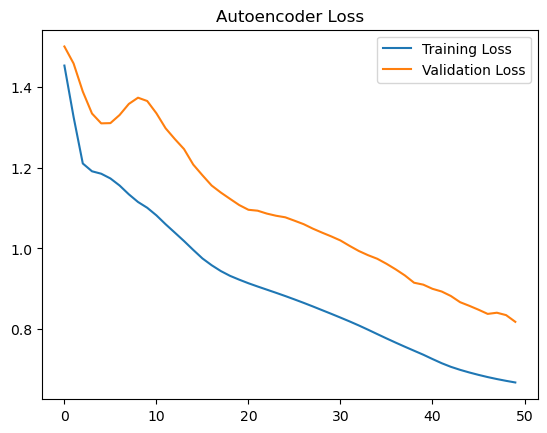

In [30]:
# Evaluate the model
loss = autoencoder.evaluate(X_test_reshaped, X_test_reshaped)
print(f"Test Loss: {loss}")

# Visualize training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Autoencoder Loss")
plt.show()


In [31]:
# Calculate reconstruction error for the test set
reconstructions = autoencoder.predict(X_test_reshaped)
reconstruction_error = np.mean(np.square(X_test_reshaped - reconstructions), axis=1)

# Set a threshold for anomalies (e.g., 95th percentile of reconstruction error)
threshold = np.percentile(reconstruction_error, 95)

# Detect anomalies
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")


7/7 [==============================] - 1s 55ms/step
Number of anomalies detected: 40


In [32]:
autoencoder.save('model/autoencoder_model/1')  # Add version number


INFO:tensorflow:Assets written to: model/autoencoder_model/1/assets


INFO:tensorflow:Assets written to: model/autoencoder_model/1/assets


In [33]:
!tar -czvf autoencoder_model.tar.gz -C model autoencoder_model


autoencoder_model/
autoencoder_model/1/
autoencoder_model/1/variables/
autoencoder_model/1/variables/variables.index
autoencoder_model/1/variables/variables.data-00000-of-00001
autoencoder_model/1/saved_model.pb
autoencoder_model/1/keras_metadata.pb
autoencoder_model/1/assets/


In [ ]:
!aws s3 cp autoencoder_model.tar.gz s3://"fill with your bucketname"/models/autoencoder_model.tar.gz


In [35]:
from sagemaker.tensorflow import TensorFlowModel
import sagemaker
model_path = 'models/autoencoder_model.tar.gz'  # S3 path to store the model
bucket_name= '' #fill with your bucketname
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = 'arn:aws:iam::YOUR-AWS-ID:role/service-role/AmazonSageMaker-ExecutionRole-20241123T164229'  # Replace with your IAM role ARN
# Define the TensorFlow model
tf_model = TensorFlowModel(
    model_data=f"s3://{bucket_name}/{model_path}",
    role=role,
    framework_version="2.9.1",  # Use TensorFlow version compatible with your model preferably the tensorflow versions:2.9.1,2.10.0,2.11
    sagemaker_session=sagemaker_session
)

In [ ]:
# Deploy the model
predictor = tf_model.deploy(
    initial_instance_count=1,  # Number of instances
    instance_type="ml.m6g.xlarge"  # Adjust instance type as needed pls refer to this aws docs page to see the instance type that are compatible with your tensorflow version ("https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler-support.html")
)

print(f"Model deployed at endpoint: {predictor.endpoint_name}")
